Prediction model for Assay degradation based on available analytic solutions to chemical kinetics. <br>
Linear:
\begin{align}
\frac{d[A]}{dt} = -  k
\end{align}
Pseudo 0.5 order up to third order
\begin{align}
\frac{d[A]}{dt} = -  k [A] ^{\frac{1}{2}}, \frac{d[A]}{dt} = -  k [A], \frac{d[A]}{dt} = -  k [A] ^{\frac{3}{2}}
\end{align}

\begin{align}
\frac{d[A]}{dt} = -  k [A] ^{2}, \frac{d[A]}{dt} = -  k [A] ^{3}, 
\end{align}

Gustafsson-Holden model
\begin{align}
\frac{d[A]}{dt} = -  \frac{k_1}{k_2} [A] \left( \frac{t}{k_2} +1 \right) ^{-1}
\end{align}

In [ ]:
#%pip install numpy
#%pip install matplotlib
#%pip install pandas
#%pip install scipy
#%pip install IPython
#%pip install ipywidgets
#%pip install scikit-learn
#%pip install openpyxl
#%pip install xlsxwriter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from IPython.display import Math, display
from scipy.stats import t
from ipywidgets import FileUpload, interact, IntSlider
import io
import csv
from matplotlib.ticker import StrMethodFormatter
import os
from sklearn.utils import resample
import ipywidgets as widgets
from IPython.display import display

In [48]:
# 1. Define folder and get list of CSVs
data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

# 2. Display the list with numbers
if not files:
    print(f"❌ No CSV files found in '{data_folder}' folder. Please upload one first!")
else:
    print("--- Available Data Files ---")
    for i, filename in enumerate(files):
        print(f"[{i}] {filename}")

--- Available Data Files ---
[0] Belosalic otopina_SD Betametazona.csv
[1] vancoB2.csv


In [ ]:
# 3. Ask for the index number
choice = input("\nEnter the number of the file you want to load: ")
    
try:
    selected_index = int(choice)
    selected_file = files[selected_index]
    file_path = os.path.join(data_folder, selected_file)
    print(f"✅ Selected: {selected_file}")
except (ValueError, IndexError):
    print("❌ Invalid selection. Please run the cell again and enter a valid number.")

✅ Selected: Belosalic otopina_SD Betametazona.csv


In [50]:
# Ensure a file was actually selected in the previous cell
if 'file_path' in locals() and os.path.exists(file_path):
    # Load the data
    data = pd.read_csv(file_path)
    
    print(f"File: {selected_file}")
    print(f"Shape: {data.shape}")
    data.info()

    if not data.empty:
        # Ask for product name
        product_name = input("\nProduct name: ")

        # Create your required variables
        headers = data.columns.tolist()
        
        # Create Assay (assuming the CSV contains numeric data)
        # We use .values to get the underlying NumPy array
        Assay = data.astype(float).values
        
        print(f"\n✅ Assay created for product: {product_name}")
        print(f"First 2 rows of Assay:\n{Assay[:2]}")
    else:
        print("⚠️ The selected file is empty.")
else:
    print("❌ No file loaded. Please run the Selection Cell above first.")

File: Belosalic otopina_SD Betametazona.csv
Shape: (30, 2)
<class 'pandas.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       30 non-null     int64  
 1   assay   30 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 612.0 bytes

✅ Assay created for product: Belosalic
First 2 rows of Assay:
[[ 3.  99.1]
 [ 6.  97.8]]


In [5]:
# Specification limit for assay/purity
spec = float(input("Specification limit: "))
print(f"Specification limit for {product_name} = {spec:.2f} %")

Specification limit for 95 = 95.00 %


In [7]:
x_data = Assay[:, 0]
y_data = Assay[:, 1]

In [8]:
print(x_data)
print(y_data)

[ 3.  6.  9. 12. 18.  3.  6.  9. 12. 18.  3.  6.  9. 12. 18.  3.  6.  9.
 12. 18.  3.  6.  9. 12. 18.  3.  6.  9. 12. 18.]
[99.1 97.8 97.7 97.1 95.5 99.2 97.5 97.5 97.  95.7 99.  97.6 97.6 97.
 95.8 99.1 97.9 97.6 96.9 95.4 99.1 97.9 97.7 97.2 95.7 99.3 97.9 97.9
 97.1 95.7]


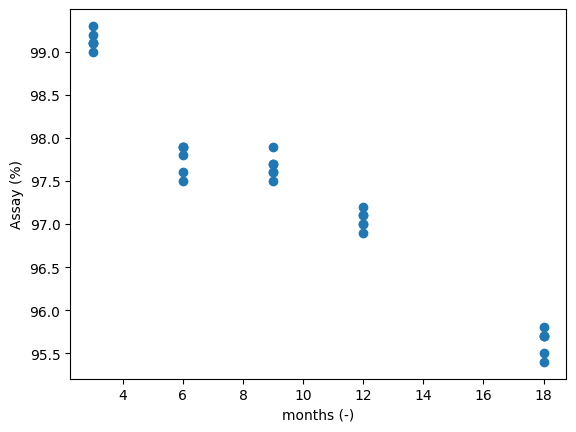

In [9]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)")
plt.ylabel("Assay (%)")
plt.show()

Choosing the initial conditions for quations with single constant k

In [10]:
initial = [99, 0.1]

Choosing initial conditions for Gustafsson Holden model

In [11]:
initial_GH = [99, 0.1, 0.01]

All the functions as analytical solutions to the differential equations written at the beginning

In [12]:
def zero_f(t, c0, k_zero):
    return c0 - k_zero * t


def half_f(t, c0, k_half):
    return ((np.sqrt(c0)) - (k_half * t * 0.5)) ** 2


def first_f(t, c0, k_first):
    return c0 * np.exp(-k_first * t)


def first_half_f(t, c0, k_firsth):
    return (1 / ((k_firsth * t * 0.5) + (1 / np.sqrt(c0)))) ** 2


def second_f(t, c0, k_second):
    return 1 / ((1 / c0) + (k_second * t))


def third_f(t, c0, k_third):
    return 1 / (np.sqrt((1 / (c0**2)) + (2 * abs(k_third) * t)))


def guho_f(t, c0, k1_gh, k2_gh):
    return c0 / (((t / k2_gh) + 1) ** k1_gh)

Non linear curve fitting for each model separately

In [13]:
popt_z, pcov_z = curve_fit(
    zero_f, x_data, y_data, p0=initial, bounds=((0, 0), (np.inf, np.inf))
)
popt_h, pcov_h = curve_fit(
    half_f, x_data, y_data, p0=initial, bounds=((0, 0), (np.inf, np.inf))
)
popt_f, pcov_f = curve_fit(
    first_f, x_data, y_data, p0=initial, bounds=((0, 0), (np.inf, np.inf))
)
popt_fh, pcov_fh = curve_fit(
    first_half_f, x_data, y_data, p0=initial, bounds=((0, 0), (np.inf, np.inf))
)
popt_s, pcov_s = curve_fit(
    second_f, x_data, y_data, p0=initial, bounds=((0, 0), (np.inf, np.inf))
)
popt_t, pcov_t = curve_fit(
    third_f, x_data, y_data, p0=initial, bounds=((0, 0), (np.inf, np.inf))
)
popt_gh, pcov_gh = curve_fit(
    guho_f, x_data, y_data, p0=initial_GH, bounds=((0, 0, 0), (np.inf, np.inf, np.inf))
)

Extraction of the fitted parameters

In [14]:
x_model = np.linspace(min(x_data), max(x_data), num=100)

c0_opt_z, k_opt_z = popt_z
y_model_z = zero_f(x_model, c0_opt_z, k_opt_z)

c0_opt_h, k_opt_h = popt_h
y_model_h = half_f(x_model, c0_opt_h, k_opt_h)

c0_opt_f, k_opt_f = popt_f
y_model_f = first_f(x_model, c0_opt_f, k_opt_f)

c0_opt_fh, k_opt_fh = popt_fh
y_model_fh = first_half_f(x_model, c0_opt_fh, k_opt_fh)

c0_opt_s, k_opt_s = popt_s
y_model_s = second_f(x_model, c0_opt_s, k_opt_s)

c0_opt_t, k_opt_t = popt_t
y_model_t = third_f(x_model, c0_opt_t, k_opt_t)

c0_opt_gh, k1_opt_gh, k2_opt_gh = popt_gh
y_model_gh = guho_f(x_model, c0_opt_gh, k1_opt_gh, k2_opt_gh)

In [15]:
print(f"{c0_opt_z:.4f}, {k_opt_z:.4f}")
print(f"{c0_opt_h:.4f}, {k_opt_h:.4f}")
print(f"{c0_opt_f:.4f}, {k_opt_f:.4f}")
print(f"{c0_opt_fh:.4f}, {k_opt_fh:.4f}")
print(f"{c0_opt_s:.4f}, {k_opt_s:.4f}")
print(f"{c0_opt_t:.4f}, {k_opt_t:.4f}")
print(f"{c0_opt_gh:.4f}, {k1_opt_gh:.4f}, {k2_opt_gh:.4f}")

99.5113, 0.2147
99.5218, 0.0218
99.5324, 0.0022
99.5430, 0.0002
99.5538, 0.0000
792.0030, 0.0000
99.7740, 0.0964, 33.4734


In [16]:
# Interpolate the model curve to the same points as the data
y_model_interp_z = np.interp(x_data, x_model, y_model_z)
y_model_interp_h = np.interp(x_data, x_model, y_model_h)
y_model_interp_f = np.interp(x_data, x_model, y_model_f)
y_model_interp_fh = np.interp(x_data, x_model, y_model_fh)
y_model_interp_s = np.interp(x_data, x_model, y_model_s)
y_model_interp_t = np.interp(x_data, x_model, y_model_t)
y_model_interp_gh = np.interp(x_data, x_model, y_model_gh)

# Calculate the residuals
residuals_z = y_data - y_model_interp_z  # residuals = observed - fitted
residuals_h = y_data - y_model_interp_h
residuals_f = y_data - y_model_interp_f
residuals_fh = y_data - y_model_interp_fh
residuals_s = y_data - y_model_interp_s
residuals_t = y_data - y_model_interp_t
residuals_gh = y_data - y_model_interp_gh

In [17]:
model_list = [
    "zero order",
    "half order",
    "first order",
    "first half order",
    "second order",
    "third order",
    "Gustafsson Holden",
]

In [ ]:
# Calculate the squared residuals for model comparison and choose the opimal model as a function
SqR_z = np.sum(np.square(residuals_z))
SqR_h = np.sum(np.square(residuals_h))
SqR_f = np.sum(np.square(residuals_f))
SqR_fh = np.sum(np.square(residuals_fh))
SqR_s = np.sum(np.square(residuals_s))
SqR_t = np.sum(np.square(residuals_t))
SqR_gh = np.sum(np.square(residuals_gh))

# Create an array of all sum of square residuals

SQR = [SqR_z, SqR_h, SqR_f, SqR_fh, SqR_s, SqR_t, SqR_gh]

"""
SQR = [SqR_z, SqR_h, SqR_f, SqR_fh, SqR_s, SqR_t, SqR_gh*1.05]
"""
# Determine the lowest Sum of square residuals
min_index, SQR_min = min(enumerate(SQR), key=lambda x: x[1])

In [44]:
model_dict = dict(zip(model_list, SQR))
for index, (key, value) in enumerate(model_dict.items(), start=0):
    print(f"{index:<5} {key:<17} - {value:.4f}")

print("\n")
print(f"First model choice, no. {min_index}, {model_list[min_index]}, {SQR_min:.4f}")

0     zero order        - 2.2700
1     half order        - 2.2624
2     first order       - 1.8042
3     first half order  - 2.2484
4     second order      - 2.2419
5     third order       - 24248.5171
6     Gustafsson Holden - 2.4011


First model choice, no. 2, first order, 1.8042


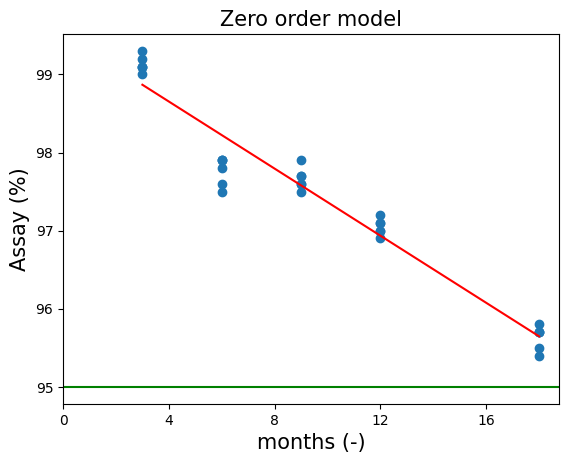

<IPython.core.display.Math object>

In [39]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Assay (%)", fontsize=15)
plt.plot(x_model, y_model_z, color="r")
plt.axhline(y=spec, color="g", linestyle="-")
plt.title("Zero order model", fontsize=15)
plt.xticks(np.arange(0, x_model[-1] + 1, 4))
plt.show()

Math(r"[Assay] = [Assay]_0-kt")

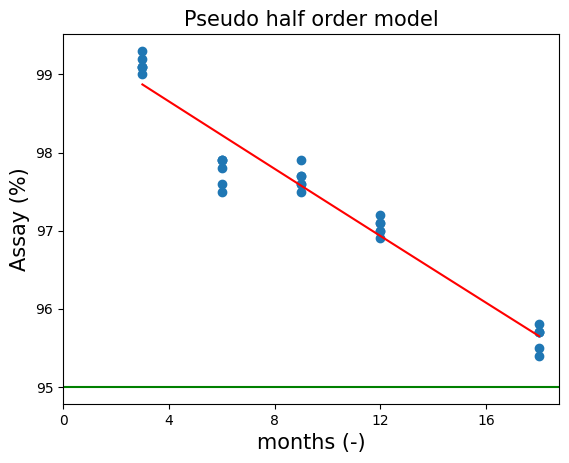

<IPython.core.display.Math object>

In [40]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Assay (%)", fontsize=15)
plt.plot(x_model, y_model_h, color="r")
plt.axhline(y=spec, color="g", linestyle="-")
plt.title("Pseudo half order model", fontsize=15)
plt.xticks(np.arange(0, x_model[-1] + 1, 4))
plt.show()

Math(r"[Assay] = \left(- \frac{kt}{2} + \sqrt{[Assay]_0}) \right)^2")

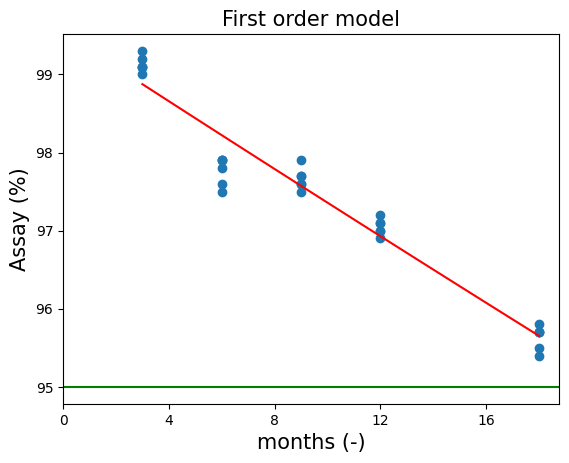

<IPython.core.display.Math object>

In [41]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Assay (%)", fontsize=15)
plt.plot(x_model, y_model_f, color="r")
plt.axhline(y=spec, color="g", linestyle="-")
plt.title("First order model", fontsize=15)
plt.xticks(np.arange(0, x_model[-1] + 1, 4))
plt.show()

Math(r"[Assay] = [Assay]_0 \: e^ {\large{-kt}}")

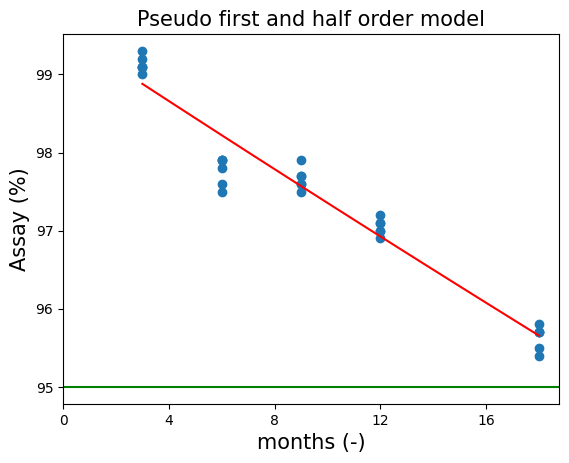

<IPython.core.display.Math object>

In [23]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Assay (%)", fontsize=15)
plt.plot(x_model, y_model_fh, color="r")
plt.axhline(y=spec, color="g", linestyle="-")
plt.title("Pseudo first and half order model", fontsize=15)
plt.xticks(np.arange(0, x_model[-1] + 1, 4))
plt.show()

Math(
    r"[Assay] = \left( \frac{1}{{\large \frac{kt}{2}} + {\large \frac{1}{\sqrt{[Assay]_0}}}} \right)^2"
)

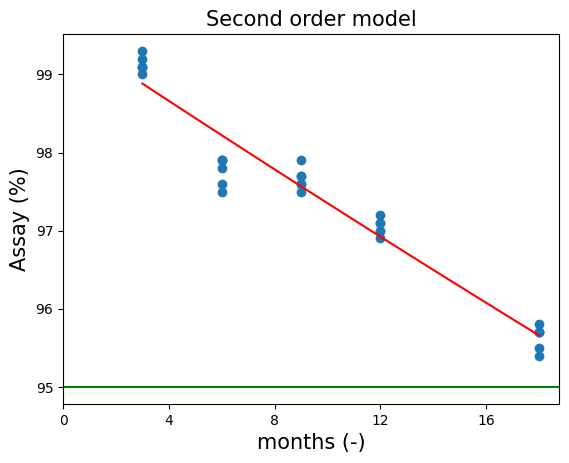

<IPython.core.display.Math object>

In [24]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Assay (%)", fontsize=15)
plt.plot(x_model, y_model_s, color="r")
plt.axhline(y=spec, color="g", linestyle="-")
plt.title("Second order model", fontsize=15)
plt.xticks(np.arange(0, x_model[-1] + 1, 4))
plt.show()

Math(r"[Assay] = \left( \frac{1}{kt + {\large \frac{1}{[Assay]_0}}} \right)")

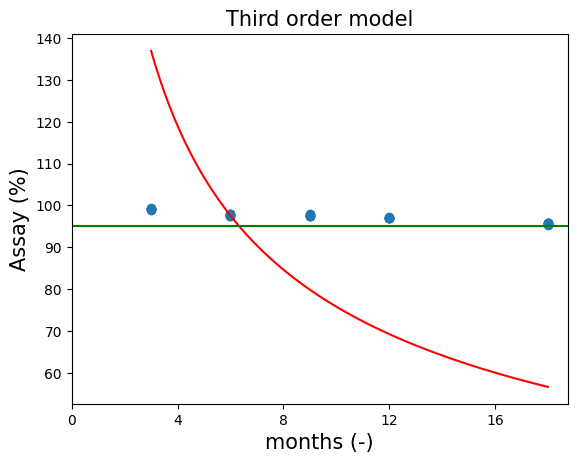

<IPython.core.display.Math object>

In [25]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Assay (%)", fontsize=15)
plt.plot(x_model, y_model_t, color="r")
plt.axhline(y=spec, color="g", linestyle="-")
plt.title("Third order model", fontsize=15)
plt.xticks(np.arange(0, x_model[-1] + 1, 4))
plt.show()

Math(r"[Assay] = \frac{1}{\sqrt{2kt + {\large \frac{1}{[Assay]_0^2}}}}")

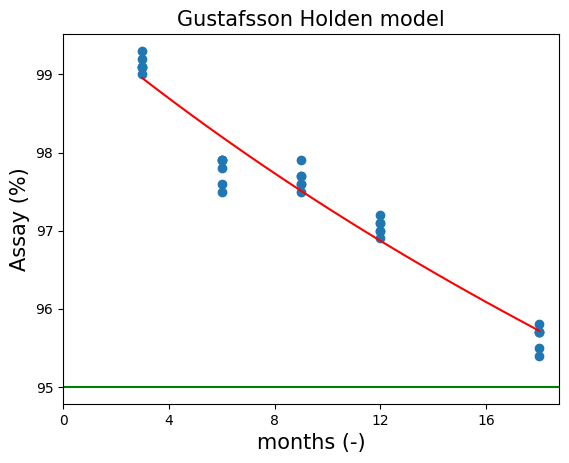

<IPython.core.display.Math object>

In [26]:
plt.scatter(x_data, y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Assay (%)", fontsize=15)
plt.plot(x_model, y_model_gh, color="r")
plt.axhline(y=spec, color="g", linestyle="-")
plt.title("Gustafsson Holden model", fontsize=15)
plt.xticks(np.arange(0, x_model[-1] + 1, 4))
plt.show()

Math(r"[Assay] = [Assay]_0 \left( \frac{t}{k_2} +1 \right) ^{-k_1}")

In [45]:
print("The best model for the data is the", model_list[min_index], "model")

# Choose the optimal function and the appropriate fitting parameters
SQR_functions = [zero_f, half_f, first_f,
                 first_half_f, second_f, third_f, guho_f]
optimal_model = SQR_functions[min_index]

fit_param = [popt_z, popt_h, popt_f, popt_fh, popt_s, popt_t, popt_gh]
best_fit_param = fit_param[min_index]
y_optimal_model = optimal_model(x_model, *best_fit_param)

#Create a list of formulas that represent the models
latex_strings = []
latex_strings.append(r"[Assay] = [Assay]_0-kt")
latex_strings.append(
    r"[Assay] = \left(- \frac{kt}{2} + \sqrt{[Assay]_0}) \right)^2")
latex_strings.append(r"[Assay] = [Assay]_0 \: e^ {\large{-kt}}")
latex_strings.append(
    r"[Assay] = \left( \frac{1}{{\large \frac{kt}{2}} + {\large \frac{1}{\sqrt{[Assay]_0}}}} \right)^2"
)
latex_strings.append(
    r"[Assay] = \left( \frac{1}{kt + {\large \frac{1}{[Assay]_0}}} \right)"
)
latex_strings.append(
    r"[Assay] = \frac{1}{\sqrt{2kt + {\large \frac{1}{[Assay]_0^2}}}}")
latex_strings.append(
    r"[Assay] = [Assay]_0 \left( \frac{t}{k_2} +1 \right) ^{-k_1}")

Math(latex_strings[min_index])

The best model for the data is the first order model


<IPython.core.display.Math object>

Bootstrap method to calculate confidence intervals for each fitting parameter

In [46]:
from scipy.optimize import minimize

if min_index < 6:
    # Number of bootstrap iterations
    n_iter = 1000

    # Store the bootstrap estimates for each parameter
    c0_bs = np.zeros(n_iter)
    k_bs = np.zeros(n_iter)

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        idx = np.random.randint(0, len(x_data), len(x_data))
        x_resample = x_data[idx]
        y_resample = y_data[idx]
        # Fit the model to the resampled data
        bounds = [(1e-10, np.inf), (1e-10, np.inf)]
        res = minimize(
            lambda p: ((optimal_model(x_resample, p[0], p[1]) - y_resample) ** 2).sum(),
            best_fit_param,
            bounds=bounds,
            method="Nelder-Mead",
        )
        c0_bs[i], k_bs[i] = res.x

    # Calculate the standard error of the bootstrap estimates
    c0_se = np.sqrt(np.mean((c0_bs - c0_bs.mean()) ** 2))
    k_se = np.sqrt(np.mean((k_bs - k_bs.mean()) ** 2))

    # Calculate the t-value for the given confidence level and degree of freedom
    alpha = 0.05  # Confidence level
    df = len(x_data) - len(best_fit_param)  # Degree of freedom
    tval = t.ppf(1 - alpha, df)

    # Calculate the confidence intervals for each parameter
    c0_ci = (best_fit_param[0] - tval * c0_se, best_fit_param[0] + tval * c0_se)
    k_ci = (best_fit_param[1] - tval * k_se, best_fit_param[1] + tval * k_se)

    # Print the confidence intervals
    print(f"c0: {best_fit_param[0]:.2f}")
    print(f"k: {best_fit_param[1]:.4f}")
    print(f"Confidence intervals for c0: ({c0_ci[0]:.2f},{c0_ci[1]:.2f})")
    print(f"Confidence intervals for k: ({k_ci[0]:.2f},{k_ci[1]:.2f})")

else:
    n_iter = 1000

    # Store the bootstrap estimates for each parameter
    c0_bs = np.zeros(n_iter)
    k1_bs = np.zeros(n_iter)
    k2_bs = np.zeros(n_iter)

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        idx = np.random.randint(0, len(x_data), len(x_data))
        x_resample = x_data[idx]
        y_resample = y_data[idx]
        # Fit the model to the resampled data
        bounds = [(1e-10, np.inf), (1e-10, np.inf), (1e-10, np.inf)]
        res = minimize(
            lambda p: ((optimal_model(x_resample, p[0], p[1], p[2]) - y_resample) ** 2).sum(),
            best_fit_param,
            bounds=bounds,
            method="Nelder-Mead",
        )
        c0_bs[i], k1_bs[i], k2_bs[i] = res.x

    # Calculate the standard error of the bootstrap estimates
    c0_se = np.sqrt(np.mean((c0_bs - c0_bs.mean()) ** 2))
    k1_se = np.sqrt(np.mean((k1_bs - k1_bs.mean()) ** 2))
    k2_se = np.sqrt(np.mean((k2_bs - k2_bs.mean()) ** 2))

    # Calculate the t-value for the given confidence level and degree of freedom
    alpha = 0.05  # Confidence level
    df = len(x_data) - len(best_fit_param)  # Degree of freedom
    tval = t.ppf(1 - alpha, df)

    # Calculate the confidence intervals for each parameter
    c0_ci = (best_fit_param[0] - tval * c0_se, best_fit_param[0] + tval * c0_se)
    k1_ci = (best_fit_param[1] - tval * k1_se, best_fit_param[1] + tval * k1_se)
    k2_ci = (best_fit_param[2] - tval * k2_se, best_fit_param[2] + tval * k2_se)

    # Print the confidence intervals
    print(f"c0: {best_fit_param[0]:.2f}")
    print(f"k1: {best_fit_param[1]:.4f}")
    print(f"k2: {best_fit_param[2]:.4f}")
    print(f"Confidence intervals for c0: ({c0_ci[0]:.2f},{c0_ci[1]:.2f})")
    print(f"Confidence intervals for k1: ({k1_ci[0]:.2f},{k1_ci[1]:.2f})")
    print(f"Confidence intervals for k2: ({k2_ci[0]:.2f},{k2_ci[1]:.2f})")

c0: 99.53
k: 0.0022
Confidence intervals for c0: (99.32,99.75)
Confidence intervals for k: (0.00,0.00)


Bootstrap method for the calculation of confidence and prediction curves for the fitted curve

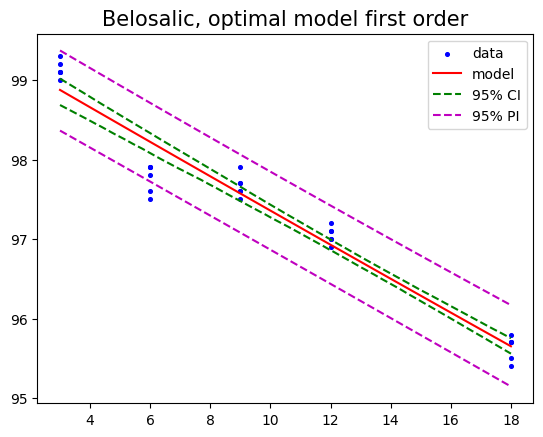

In [47]:
n_points = 100

if min_index < 6:
    # x-values for the model curve are x_model

    # Store the y-values for the model curve for each bootstrap iteration for confidence and prediction intervals
    y_model_bs = np.zeros((n_iter, n_points))
    y_pred_bs = np.zeros((n_iter, n_points))

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        idx = np.random.randint(0, len(x_data), len(x_data))
        x_resample = x_data[idx]
        y_resample = y_data[idx]
        # Fit the model to the resampled data
        res_c = minimize(
            lambda p: ((optimal_model(x_resample, p[0], p[1]) - y_resample) ** 2).sum(),
            best_fit_param,
            method="Nelder-Mead",
        )
        c0_bs_c, k_bs_c = res_c.x
        # Calculate y-values for the model curve for this iteration
        y_model_bs[i, :] = optimal_model(x_model, c0_bs_c, k_bs_c)

    # Calculate lower and upper bounds of the confidence interval for each point on the x-axis
    alpha = 0.05
    lower_bound = np.percentile(y_model_bs, alpha * 100, axis=0)
    upper_bound = np.percentile(y_model_bs, (1 - alpha) * 100, axis=0)

    # Calculate lower and upper bounds of the prediction interval for each point on the x-axis
    alpha = 0.05
    sigma_squared = ((y_data - optimal_model(x_data, best_fit_param[0], best_fit_param[1])) ** 2
    ).sum() / (len(x_data) - len(best_fit_param))
    tval = t.ppf(1 - alpha, len(x_data) - len(best_fit_param))

    lower_bound_p = y_model_bs.mean(axis=0) - tval * np.sqrt(sigma_squared) * np.sqrt(
        1 + 1 / len(x_data) + (x_model - x_data.mean()) ** 2 / ((x_data - x_data.mean()) ** 2).sum()
    )
    upper_bound_p = y_model_bs.mean(axis=0) + tval * np.sqrt(sigma_squared) * np.sqrt(
        1 + 1 / len(x_data) + (x_model - x_data.mean()) ** 2 / ((x_data - x_data.mean()) ** 2).sum()
    )

    # Plot the model curve and the confidence interval bounds
    plt.scatter(x_data, y_data, label="data", marker="o", color="blue", s=7)
    plt.plot(x_model, y_optimal_model, "r-", label="model")
    plt.plot(x_model, lower_bound, "g--", label="95% CI")
    plt.plot(x_model, upper_bound, "g--")
    plt.plot(x_model, lower_bound_p, "m--", label="95% PI")
    plt.plot(x_model, upper_bound_p, "m--")
    plt.title(f"{product_name}, optimal model {model_list[min_index]}", fontsize=15)
    plt.legend()
    plt.show()

else:
    # x-values for the model curve are x_model

    # Store the y-values for the model curve for each bootstrap iteration for confidence and prediction intervals
    y_model_bs = np.zeros((n_iter, n_points))
    y_pred_bs = np.zeros((n_iter, n_points))

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        idx = np.random.randint(0, len(x_data), len(x_data))
        x_resample = x_data[idx]
        y_resample = y_data[idx]
        # Fit the model to the resampled data
        res = minimize(
            lambda p: (
                (optimal_model(x_resample, p[0], p[1], p[2]) - y_resample) ** 2).sum(),
            best_fit_param,
            method="Nelder-Mead",
        )
        c0_bs, k1_bs, k2_bs = res.x
        # Calculate y-values for the model curve for this iteration
        y_model_bs[i, :] = optimal_model(x_model, c0_bs, k1_bs, k2_bs)

    # Calculate lower and upper bounds of the confidence interval for each point on the x-axis
    alpha = 0.05
    lower_bound = np.percentile(y_model_bs, alpha * 100, axis=0)
    upper_bound = np.percentile(y_model_bs, (1 - alpha) * 100, axis=0)

    # Calculate lower and upper bounds of the prediction interval for each point on the x-axis
    alpha = 0.05
    sigma_squared = (
        (y_data - optimal_model(x_data, best_fit_param[0], best_fit_param[1], best_fit_param[2]))** 2
    ).sum() / (len(x_data) - len(best_fit_param))
    tval = t.ppf(1 - alpha, len(x_data) - len(best_fit_param))

    lower_bound_p = y_model_bs.mean(axis=0) - tval * np.sqrt(sigma_squared) * np.sqrt(
        1 + 1 / len(x_data) + (x_model - x_data.mean()) ** 2 / ((x_data - x_data.mean()) ** 2).sum()
    )
    upper_bound_p = y_model_bs.mean(axis=0) + tval * np.sqrt(sigma_squared) * np.sqrt(
        1 + 1 / len(x_data) + (x_model - x_data.mean()) ** 2 / ((x_data - x_data.mean()) ** 2).sum()
    )

    # Plot the model curve and the confidence interval bounds
    plt.scatter(x_data, y_data, label="data", marker="o", color="blue", s=7)
    plt.plot(x_model, y_optimal_model, "r-", label="model")
    plt.plot(x_model, lower_bound, "g--", label="95% CI")
    plt.plot(x_model, upper_bound, "g--")
    plt.plot(x_model, lower_bound_p, "m--", label="95% PI")
    plt.plot(x_model, upper_bound_p, "m--")
    plt.title(f"{product_name}, optimal model {model_list[min_index]}", fontsize=15)
    plt.axhline(y=spec, color="g", linestyle="-")
    plt.legend()
    plt.show()
    display(Math(latex_strings[min_index]))

In [30]:
#Create dataframe for the results of the optimization
if min_index < 6:
    print(f"[Assay]0 = {best_fit_param[0]:.2f}")
    print(f"k = {best_fit_param[1]:.4f}")
    print(f"Confidence intervals for c0:{c0_ci[0]:.4f} to {c0_ci[1]:.4f}")
    print(f"Confidence intervals for k1:{k_ci[0]:.4f} to {k_ci[1]:.4f}")
    parameters_df = pd.DataFrame(
        {
            "Product/parameter": [product_name, " "],
            "model": [model_list[min_index], " "],
            "[Assay]0": best_fit_param[0],
            "k": best_fit_param[1],
            "Confidence intervals for c0": c0_ci,
            "Confidence intervals for k": k_ci,
        }
    )

else:
    print(f"[Assay]0 = {best_fit_param[0]:.2f}")
    print(f"k1 = {best_fit_param[1]:.4f}")
    print(f"k2 = {best_fit_param[2]:.4f}")
    print(f"Confidence intervals for c0: {c0_ci[0]:.2f} to {c0_ci[1]:.2f}")
    print(f"Confidence intervals for k1: {k1_ci[0]:.4f} to {k1_ci[1]:.4f}")
    print(f"Confidence intervals for k2: {k2_ci[0]:.4f} to {k2_ci[1]:.4f}")
    parameters_df = pd.DataFrame(
        {
            "Name": [product_name, " ", " "],
            "model": [model_list[min_index], " ", " "],
            "Fit param.": ["C0", "k1", "k2"],
            " ": [best_fit_param[0], best_fit_param[1], best_fit_param[2]],
            "Lower CI": [c0_ci[0], k1_ci[0], k2_ci[0]],
            "Higher CI": [c0_ci[1], k1_ci[1], k2_ci[1]],
        }
    )

# Create 'results' directory if it doesn't exist
if not os.path.exists("results"):
    os.makedirs("results")

result_df = pd.DataFrame(
    {
        "time": x_model,
        "assay": y_optimal_model,
        "95% LCI": lower_bound,
        "95% UCI": upper_bound,
        "95% LPI": lower_bound_p,
        "95% UPI": upper_bound_p,
    }
)


result_df.to_csv(os.path.join("results", f"{product_name}_assay_calc.csv"), index=False)
# result_df.to_excel(os.path.join('results', f'{product_name}_assay_calc.xlsx'), index=False)
display(parameters_df)

[Assay]0 = 99.77
k1 = 0.0964
k2 = 33.4734
Confidence intervals for c0: 98.87 to 100.67
Confidence intervals for k1: -233782.5632 to 233782.7560
Confidence intervals for k2: -109784106.0235 to 109784172.9703


,Name,model,Fit param.,,Lower CI,Higher CI
0,Belosalic,Gustafsson Holden,C0,99.774036,9.887408e+01,1.006740e+02
1,,,k1,0.096422,-2.337826e+05,2.337828e+05
2,,,k2,33.473422,-1.097841e+08,1.097842e+08


In [31]:
# Concatenate the two DataFrames along the columns (axis=1)
combined_df = pd.concat([result_df, parameters_df], axis=1)
combined_df.to_excel(
    os.path.join("results", f"{product_name}_assay_calc.xlsx"), index=False
)

In [32]:
excel_file_path = os.path.join("results", f"{product_name}_assay_calc.xlsx")

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(excel_file_path, engine="xlsxwriter")

# Position the dataframes in the worksheet.
result_df.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=0, header=True, index=False
)
data.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=6, header=True, index=False
)
parameters_df.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=8, header=True, index=False
)

# Access the XlsxWriter workbook and worksheet objects from the dataframe.
workbook = writer.book
worksheet = writer.sheets["Sheet1"]

# Create a chart object.
chart = workbook.add_chart({"type": "scatter", "subtype": "smooth"})
chart.set_title({"name": f"Assay degradation of {product_name}"})

# Define a list of colors to cycle through
colors = ["red", "green", "green", "purple", "purple"]

# Configure the series of the chart from the dataframe data.
for i, col_name in enumerate(
    result_df.columns[1:]
):  # Start from the second column (y-axis values)
    row_start = 2  # Assuming the data starts from the second row
    row_end = len(result_df) + 1
    col_letter = chr(
        ord("B") + i
    )  # transforming the B column to integer to add i and then converting back to column letter

    chart.add_series(
        {
            "name": col_name,
            "values": f"=Sheet1!${col_letter}${row_start}:${col_letter}${row_end}",
            "categories": f"=Sheet1!$A${row_start}:$A${row_end}",
            "line": {"color": colors[i]},  # Set the color from the list
        }
    )

# Insert the chart into the worksheet.
worksheet.insert_chart("J5", chart)

writer.close()

Making a prediction for a longer time period for the same fitted parameters as the optimal model

In [33]:
predic_period = int(input("Months of prediction = "))

In [34]:
x_model_p = np.linspace(min(x_data), predic_period, num=200)
y_model_p = optimal_model(x_model_p, *best_fit_param)

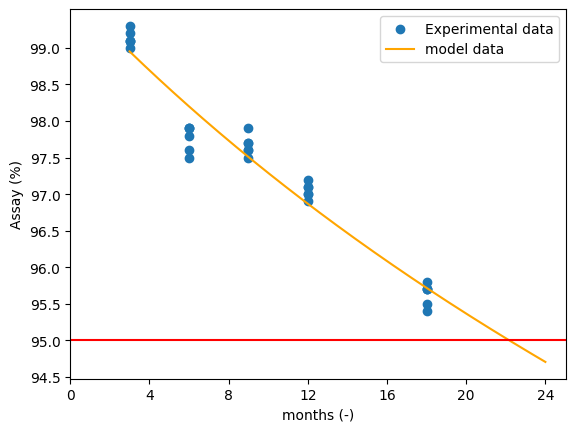

<IPython.core.display.Math object>

The value for assay of Belosalic at 24 months will be 94.71%


In [35]:
plt.scatter(x_data, y_data, label="Experimental data")
plt.xlabel("months (-)")
plt.ylabel("Assay (%)")
plt.plot(x_model_p, y_model_p, color="orange", label="model data")
plt.axhline(y=spec, color="red", linestyle="-")
y_axis = np.arange(spec - 0.5, np.max(y_model_p) + 0.5, 0.5)
plt.xticks(np.arange(0, x_model_p[-1] + 1, 4))
plt.yticks(y_axis)
plt.legend()
plt.show()
display(Math(latex_strings[min_index]))
print(
    f"The value for assay of {product_name} at {x_model_p[-1]:.0f} months will be {y_model_p[-1]:.2f}%"
)

In [36]:
from scipy.optimize import fsolve


def find_intersection(func, target_y, x_range, *params):
    # Define a function that represents the difference between the model and the target y
    diff_func = lambda x: func(x, *params) - target_y

    # Use fsolve to find the root (intersection point)
    intersection_x = fsolve(diff_func, x_range)

    return intersection_x[0] if len(intersection_x) > 0 else None


# Find the intersection for y = spec limit
target_y = spec
x_range = (min(x_model_p), max(x_model_p))  # Adjust the range based on your data
intersection_x = find_intersection(optimal_model, target_y, x_range, *best_fit_param)

if intersection_x is not None:
    print(
        f"The time value where the model intersects with {target_y}% is at {intersection_x:.2f} months"
    )
else:
    print(f"No intersection found within the given range.")

The time value where the model intersects with 95.0% is at 22.19 months
